### Initial Data Set Up

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
import hvplot
import hvplot.pandas
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date
from bokeh.models import Range1d, LinearAxis
from bokeh.models.renderers import GlyphRenderer
from sklearn import metrics
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance') #note data pulling from Binance
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

### We set the ticker first and the data we require to be pulled from the API

In [2]:
# Data function to get data depending on timeframe
# note API limit to 1000 units
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '1000D'
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    df = df.loc[df.index <= end_date] # to ensure date range goes only to end date
    
    return df

In [3]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '16/07/2018' #3Y 'long term model' example - 1095 days
end_date = '15/07/2021'
time_frame = '1d' 
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [4]:
btc_df = raw_df.copy()

In [5]:
btc_df

Open      High       Low     Close        Volume
Timestamp                                                       
2018-07-16   6354.15   6747.30   6330.40   6723.35  36204.877080
2018-07-17   6723.33   7468.99   6652.04   7317.44  52105.423459
2018-07-18   7317.44   7588.08   7225.38   7381.90  59487.643450
2018-07-19   7381.88   7576.28   7270.00   7466.21  41218.256437
2018-07-20   7468.86   7700.00   7273.00   7337.53  46140.313447
...              ...       ...       ...       ...           ...
2021-07-11  33502.87  34666.00  33306.47  34258.99  31572.647448
2021-07-12  34259.00  34678.43  32658.34  33086.63  48181.403762
2021-07-13  33086.94  33340.00  32202.25  32729.77  41126.361008
2021-07-14  32729.12  33114.03  31550.00  32820.02  46777.823484
2021-07-15  32820.03  33185.25  31133.00  31880.00  51639.576353

[1096 rows x 5 columns]

In [6]:
# Drop NAs and calculate daily percent return
btc_df["period_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(7) #to capture change in last 24hrs or units of time (for short term 24hrs, long term 7 days)

# Display sample data
btc_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-16  6354.15  6747.30  6330.40  6723.35  36204.877080            NaN   
2018-07-17  6723.33  7468.99  6652.04  7317.44  52105.423459       0.088362   
2018-07-18  7317.44  7588.08  7225.38  7381.90  59487.643450       0.008809   
2018-07-19  7381.88  7576.28  7270.00  7466.21  41218.256437       0.011421   
2018-07-20  7468.86  7700.00  7273.00  7337.53  46140.313447      -0.017235   

            target  
Timestamp           
2018-07-16     NaN  
2018-07-17     NaN  
2018-07-18     NaN  
2018-07-19     NaN  
2018-07-20     NaN

In [7]:
hounds_cap_investment = 40000

### Exponential Weighted Moving Average Indicator

In [8]:
# Set short and long windows
short_window = 3
long_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Crossover trading indicator
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]
btc_df['Cross Entry/Exit'] = btc_df["crossover_signal"].diff()
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].replace(-2,-1).replace(2,1)

#btc_df.loc[btc_df['Cross Entry/Exit']==1]


In [9]:
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].fillna(0)

In [10]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Cross Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Cross Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [11]:
btc_df.tail()

Open      High       Low     Close        Volume  \
Timestamp                                                          
2021-07-11  33502.87  34666.00  33306.47  34258.99  31572.647448   
2021-07-12  34259.00  34678.43  32658.34  33086.63  48181.403762   
2021-07-13  33086.94  33340.00  32202.25  32729.77  41126.361008   
2021-07-14  32729.12  33114.03  31550.00  32820.02  46777.823484   
2021-07-15  32820.03  33185.25  31133.00  31880.00  51639.576353   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2021-07-11       0.022569 -0.029119  33922.298335  34997.807204   
2021-07-12      -0.034221 -0.017914  33749.900397  34869.821384   
2021-07-13      -0.010786 -0.043549  33539.448032  34726.508545   
2021-07-14       0.002757 -0.030775  33391.030408  34598.836710   
2021-07-15      -0.028642 -0.030287  33079.305629  34416.764349   

            crossover_long  crossover_short  crossover_signal  \
Timestamp                                                       
2021-07-11             0.0             -1.0              -1.0   
2021-07-12             0.0             -1.0              -1.0   
2021-07-13             0.0             -1.0              -1.0   
2021-07-14             0.0             -1.0              -1.0   
2021-07-15             0.0             -1.0              -1.0   

            Cross Entry/Exit  Portfolio Cash  Coin Holdings  \
Timestamp                                                     
2021-07-11               0.0   389983.704131            0.0   
2021-07-12               0.0   389983.704131            0.0   
2021-07-13               0.0   389983.704131            0.0   
2021-07-14               0.0   389983.704131            0.0   
2021-07-15               0.0   389983.704131            0.0   

            Portfolio Holdings  Portfolio Total  Portfolio Returns  \
Timestamp                                                            
2021-07-11                 0.0    389983.704131                0.0   
2021-07-12                 0.0    389983.704131                0.0   
2021-07-13                 0.0    389983.704131                0.0   
2021-07-14                 0.0    389983.704131                0.0   
2021-07-15                 0.0    389983.704131                0.0   

            Portolio Cumulative Returns  
Timestamp                                
2021-07-11                     8.749593  
2021-07-12                     8.749593  
2021-07-13                     8.749593  
2021-07-14                     8.749593  
2021-07-15                     8.749593

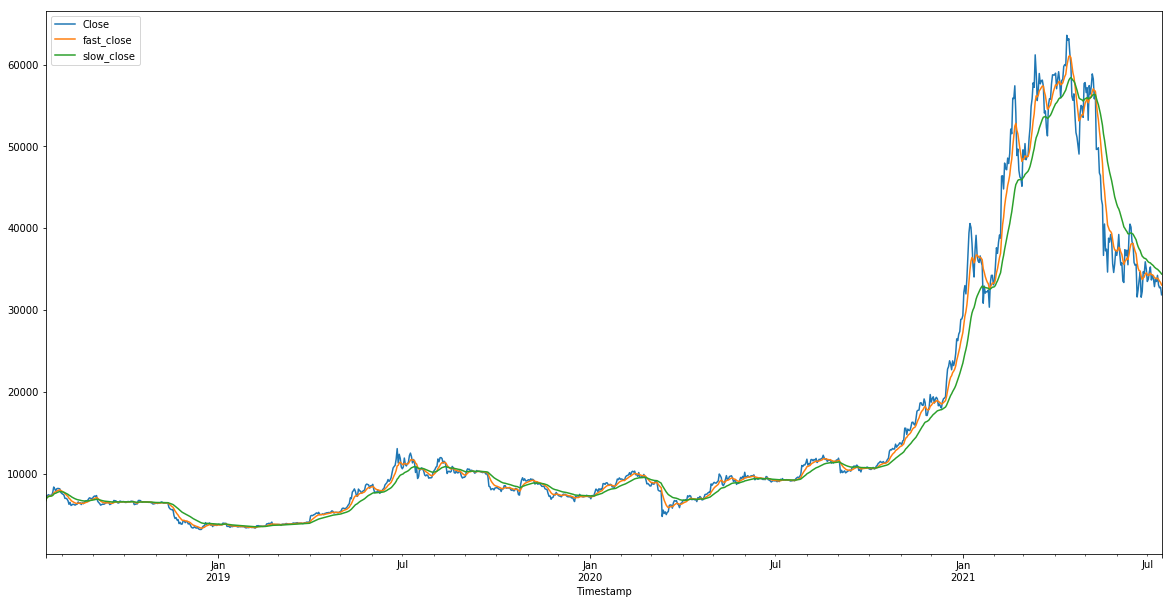

In [12]:
# Plot EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

In [13]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Cross Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Cross Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['fast_close', 'slow_close']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [14]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')
plt.savefig("EMA.png")

<Figure size 432x288 with 0 Axes>

In [15]:
# Return last value of dataframe to pull into lambda code
EMA = btc_df['Portfolio Total'].iloc[-1]
EMA

389983.70413114835

### Simple Moving Average

In [16]:
short_window = 7
long_window = 25

btc_df['ma_short'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['ma_long'] = btc_df['Close'].rolling(window=long_window).mean()

btc_df['ma_signal'] = 0
btc_df['ma_signal'] = np.where(btc_df['ma_short']>btc_df['ma_long'],1,0)
btc_df['Entry/Exit'] = btc_df['ma_signal'].diff()


In [17]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [18]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['ma_short', 'ma_long']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

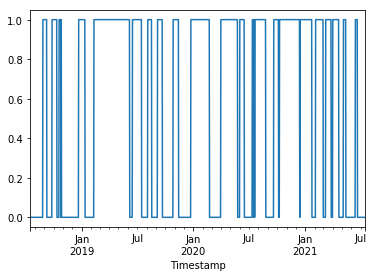

In [19]:
# Showing Bitcoin position at any time
btc_df['Entry/Exit'].cumsum().plot()

In [20]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [21]:
# Return last value of dataframe to pull into lambda code
SMA = btc_df['Portfolio Total'].iloc[-1]
SMA

284923.679692713

### Volatility Indicator

In [22]:
# Set short and long volatility windows
short_vol_window = 7
long_vol_window = 25

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_vol"] = btc_df["period_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["period_return"].ewm(halflife=long_vol_window).std()

# Crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = (btc_df["vol_trend_long"] + btc_df["vol_trend_short"]).diff()
btc_df["vol_trend_signal"] = btc_df["vol_trend_signal"].replace(-2,-1).replace(2,1)

btc_df

Open      High       Low     Close        Volume  \
Timestamp                                                          
2018-07-16   6354.15   6747.30   6330.40   6723.35  36204.877080   
2018-07-17   6723.33   7468.99   6652.04   7317.44  52105.423459   
2018-07-18   7317.44   7588.08   7225.38   7381.90  59487.643450   
2018-07-19   7381.88   7576.28   7270.00   7466.21  41218.256437   
2018-07-20   7468.86   7700.00   7273.00   7337.53  46140.313447   
...              ...       ...       ...       ...           ...   
2021-07-11  33502.87  34666.00  33306.47  34258.99  31572.647448   
2021-07-12  34259.00  34678.43  32658.34  33086.63  48181.403762   
2021-07-13  33086.94  33340.00  32202.25  32729.77  41126.361008   
2021-07-14  32729.12  33114.03  31550.00  32820.02  46777.823484   
2021-07-15  32820.03  33185.25  31133.00  31880.00  51639.576353   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2018-07-16            NaN       NaN   6723.350000   6723.350000   
2018-07-17       0.088362       NaN   7054.559135   7030.685675   
2018-07-18       0.008809       NaN   7189.619632   7155.959033   
2018-07-19       0.011421       NaN   7284.223747   7241.762419   
2018-07-20      -0.017235       NaN   7300.277375   7263.658687   
...                   ...       ...           ...           ...   
2021-07-11       0.022569 -0.029119  33922.298335  34997.807204   
2021-07-12      -0.034221 -0.017914  33749.900397  34869.821384   
2021-07-13      -0.010786 -0.043549  33539.448032  34726.508545   
2021-07-14       0.002757 -0.030775  33391.030408  34598.836710   
2021-07-15      -0.028642 -0.030287  33079.305629  34416.764349   

            crossover_long  ...  Portolio Cumulative Returns      ma_short  \
Timestamp                   ...                                              
2018-07-16             0.0  ...                          NaN           NaN   
2018-07-17             1.0  ...                     0.000000           NaN   
2018-07-18             1.0  ...                     0.000000           NaN   
2018-07-19             1.0  ...                     0.000000           NaN   
2018-07-20             1.0  ...                     0.000000           NaN   
...                    ...  ...                          ...           ...   
2021-07-11             0.0  ...                     6.123092  33746.521429   
2021-07-12             0.0  ...                     6.123092  33660.305714   
2021-07-13             0.0  ...                     6.123092  33447.414286   
2021-07-14             0.0  ...                     6.123092  33298.542857   
2021-07-15             0.0  ...                     6.123092  33156.298571   

               ma_long  ma_signal  Entry/Exit  fast_vol  slow_vol  \
Timestamp                                                           
2018-07-16         NaN          0         NaN       NaN       NaN   
2018-07-17         NaN          0         0.0       NaN       NaN   
2018-07-18         NaN          0         0.0  0.056253  0.056253   
2018-07-19         NaN          0         0.0  0.044010  0.044869   
2018-07-20         NaN          0         0.0  0.044036  0.045141   
...                ...        ...         ...       ...       ...   
2021-07-11  34197.9572          0         0.0  0.036632  0.046533   
2021-07-12  33997.7036          0         0.0  0.036377  0.046194   
2021-07-13  33874.1008          0         0.0  0.034702  0.045577   
2021-07-14  33767.5528          0         0.0  0.033080  0.044960   
2021-07-15  33618.7464          0         0.0  0.032408  0.044540   

            vol_trend_long  vol_trend_short  vol_trend_signal  
Timestamp                                                      
2018-07-16             0.0              0.0               NaN  
2018-07-17             0.0              0.0               0.0  
2018-07-18             0.0              0.0               0.0  
2018-07-19             1.0

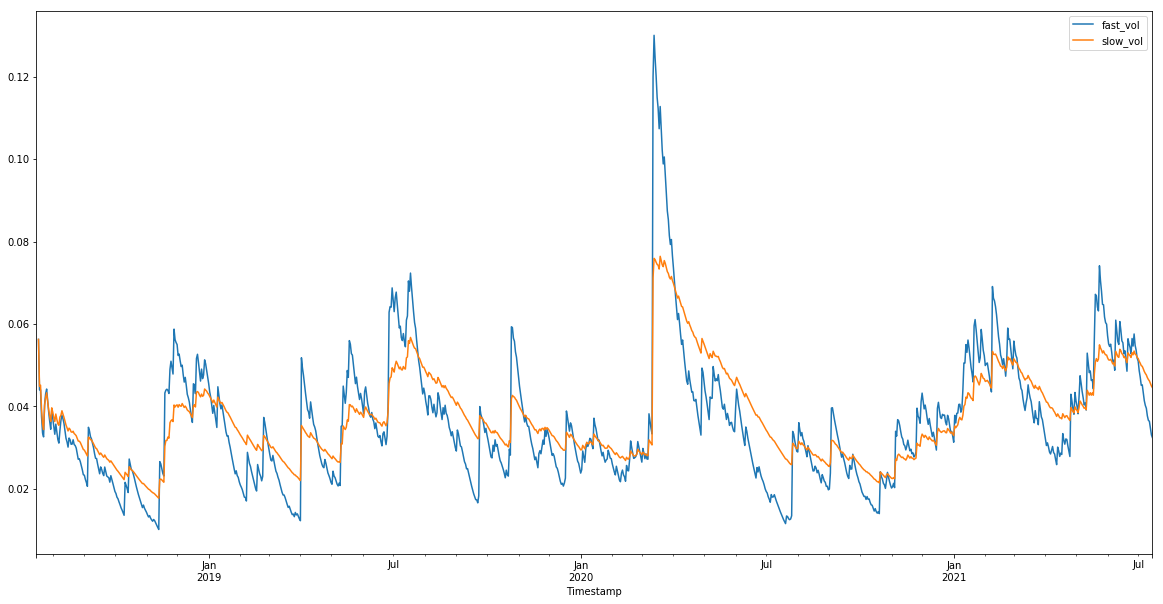

In [23]:
# Plot EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

In [24]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['vol_trend_signal'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['vol_trend_signal'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [25]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['vol_trend_signal']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['vol_trend_signal']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [26]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [27]:
# Return last value of dataframe to pull into lambda code
VOL = btc_df['Portfolio Total'].iloc[-1]
VOL

241834.7121092535

### Bollinger Bands Indicator

In [28]:
# Set bollinger band window
bollinger_window = 20

# Rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_long"] = np.where(btc_df["Close"] > btc_df["bollinger_lower_band"], -1.0, 0.0)

# inferred correlation between long and short indicators so decided to just use long - would make the model more advanced and assess correlation between both 
#btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], 1.0, 0.0)
#btc_df["bollinger_short"] = np.where(btc_df["Close"] < btc_df["bollinger_upper_band"], -1.0, 0.0)

btc_df["bollinger_signal"] = btc_df["bollinger_long"] # + btc_df["bollinger_short"] - remove if only using one band
btc_df["bollinger_signal"] = btc_df["bollinger_signal"].diff()
#btc_df["vol_trend_signal"] = btc_df["vol_trend_signal"].replace(-2,-1).replace(2,1)

btc_df

Open      High       Low     Close        Volume  \
Timestamp                                                          
2018-07-16   6354.15   6747.30   6330.40   6723.35  36204.877080   
2018-07-17   6723.33   7468.99   6652.04   7317.44  52105.423459   
2018-07-18   7317.44   7588.08   7225.38   7381.90  59487.643450   
2018-07-19   7381.88   7576.28   7270.00   7466.21  41218.256437   
2018-07-20   7468.86   7700.00   7273.00   7337.53  46140.313447   
...              ...       ...       ...       ...           ...   
2021-07-11  33502.87  34666.00  33306.47  34258.99  31572.647448   
2021-07-12  34259.00  34678.43  32658.34  33086.63  48181.403762   
2021-07-13  33086.94  33340.00  32202.25  32729.77  41126.361008   
2021-07-14  32729.12  33114.03  31550.00  32820.02  46777.823484   
2021-07-15  32820.03  33185.25  31133.00  31880.00  51639.576353   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2018-07-16            NaN       NaN   6723.350000   6723.350000   
2018-07-17       0.088362       NaN   7054.559135   7030.685675   
2018-07-18       0.008809       NaN   7189.619632   7155.959033   
2018-07-19       0.011421       NaN   7284.223747   7241.762419   
2018-07-20      -0.017235       NaN   7300.277375   7263.658687   
...                   ...       ...           ...           ...   
2021-07-11       0.022569 -0.029119  33922.298335  34997.807204   
2021-07-12      -0.034221 -0.017914  33749.900397  34869.821384   
2021-07-13      -0.010786 -0.043549  33539.448032  34726.508545   
2021-07-14       0.002757 -0.030775  33391.030408  34598.836710   
2021-07-15      -0.028642 -0.030287  33079.305629  34416.764349   

            crossover_long  ...  slow_vol  vol_trend_long  vol_trend_short  \
Timestamp                   ...                                              
2018-07-16             0.0  ...       NaN             0.0              0.0   
2018-07-17             1.0  ...       NaN             0.0              0.0   
2018-07-18             1.0  ...  0.056253             0.0              0.0   
2018-07-19             1.0  ...  0.044869             1.0              0.0   
2018-07-20             1.0  ...  0.045141             1.0              0.0   
...                    ...  ...       ...             ...              ...   
2021-07-11             0.0  ...  0.046533             1.0              0.0   
2021-07-12             0.0  ...  0.046194             1.0              0.0   
2021-07-13             0.0  ...  0.045577             1.0              0.0   
2021-07-14             0.0  ...  0.044960             1.0              0.0   
2021-07-15             0.0  ...  0.044540             1.0              0.0   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-07-16               NaN                 NaN            NaN   
2018-07-17               0.0                 NaN            NaN   
2018-07-18               0.0                 NaN            NaN   
2018-07-19               1.0                 NaN            NaN   
2018-07-20               0.0                 NaN            NaN   
...                      ...                 ...            ...   
2021-07-11               0.0          33917.1655    1052.808472   
2021-07-12               0.0          33946.0190    1019.584368   
2021-07-13               0.0          33898.6040    1054.164541   
2021-07-14               0.0          33806.4505    1064.327164   
2021-07-15               0.0          33821.2280    1033.456433   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-07-16                   NaN                   NaN             0.0   
2018-07-17                   NaN                   NaN             0.0   
2018-07-18                   NaN                   NaN             0.0   
20

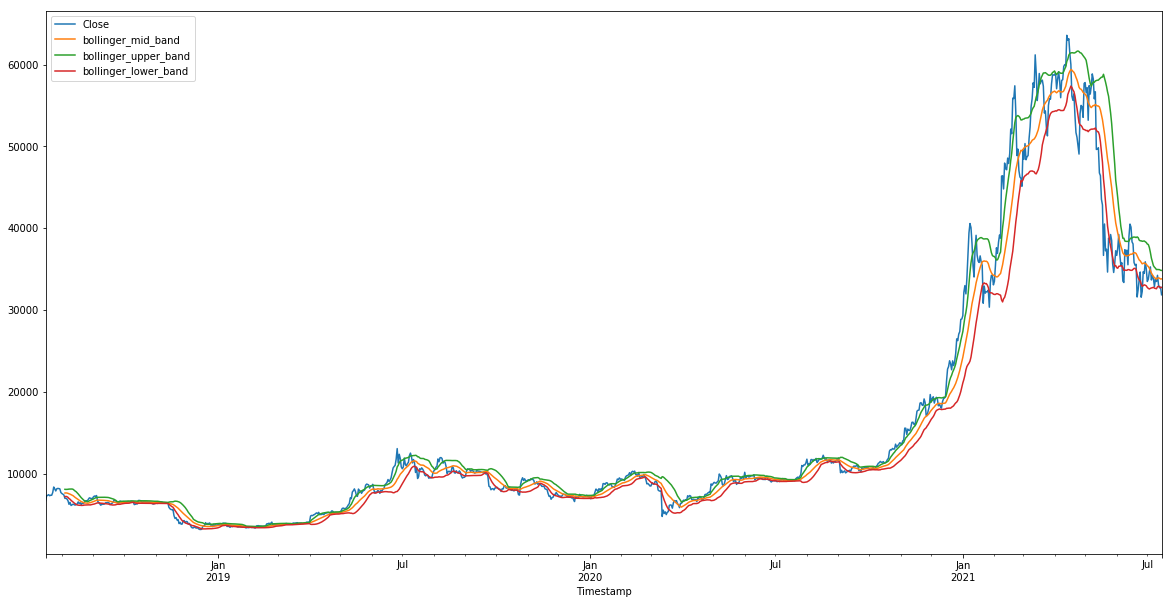

In [29]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

In [108]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['bollinger_signal'] == 1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['bollinger_signal'] == -1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize upper bollinger band - for strategy
moving_avgs = btc_df['bollinger_upper_band'].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * entry * moving_avgs * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Timestamp]   (Close)
   .Scatter.Close.I            :Scatter   [Timestamp]   (Close)
   .Curve.Bollinger_upper_band :Curve   [Timestamp]   (bollinger_upper_band)
   .Scatter.Close.II           :Scatter   [Timestamp]   (Close)

In [31]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['bollinger_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['bollinger_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [32]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [33]:
# Return last value of dataframe to pull into lambda code
BOL = btc_df['Portfolio Total'].iloc[-1]
BOL

161522.50065741697

### RSI Indicator

In [34]:
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

btc_df["rsi_long"] = np.where(btc_df["rsi"] < 20, 1.0, 0.0)
btc_df["rsi_long"] = np.where(btc_df["rsi"] > 60, -1.0, 0.0)

btc_df["rsi_signal"] = btc_df["rsi_long"].diff().fillna(0)

In [35]:
btc_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-16  6354.15  6747.30  6330.40  6723.35  36204.877080            NaN   
2018-07-17  6723.33  7468.99  6652.04  7317.44  52105.423459       0.088362   
2018-07-18  7317.44  7588.08  7225.38  7381.90  59487.643450       0.008809   
2018-07-19  7381.88  7576.28  7270.00  7466.21  41218.256437       0.011421   
2018-07-20  7468.86  7700.00  7273.00  7337.53  46140.313447      -0.017235   

            target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                     ...   
2018-07-16     NaN  6723.350000  6723.350000             0.0  ...   
2018-07-17     NaN  7054.559135  7030.685675             1.0  ...   
2018-07-18     NaN  7189.619632  7155.959033             1.0  ...   
2018-07-19     NaN  7284.223747  7241.762419             1.0  ...   
2018-07-20     NaN  7300.277375  7263.658687             1.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-07-16               NaN                 NaN            NaN   
2018-07-17               0.0                 NaN            NaN   
2018-07-18               0.0                 NaN            NaN   
2018-07-19               1.0                 NaN            NaN   
2018-07-20               0.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-07-16                   NaN                   NaN             0.0   
2018-07-17                   NaN                   NaN             0.0   
2018-07-18                   NaN                   NaN             0.0   
2018-07-19                   NaN                   NaN             0.0   
2018-07-20                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2018-07-16               NaN  NaN       0.0         0.0  
2018-07-17               0.0  NaN       0.0         0.0  
2018-07-18               0.0  NaN       0.0         0.0  
2018-07-19               0.0  NaN       0.0         0.0  
2018-07-20               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [109]:
# Visualize exit position relative to Close price
entry = btc_df[btc_df['rsi_signal'] == 1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
exit = btc_df[btc_df['rsi_signal'] == -1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize - overlay onto secondary axis
def apply_formatter(plot, element):
    p = plot.state
    
    # create secondary range and axis
    p.extra_y_ranges = {"twiny": Range1d(start=0, end=1000)}
    p.add_layout(LinearAxis(y_range_name="twiny"), 'right')
    glyph = p.select(dict(type=GlyphRenderer))[0]
    glyph.y_range_name = 'twiny'

rsi_plot = btc_df["rsi"].hvplot(ylabel='Price in $',width=1000,height=400).opts(hooks=[apply_formatter])

# Overlay plots
entry_exit_plot = price * rsi_plot * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Curve.Rsi        :Curve   [Timestamp]   (rsi)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [37]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['rsi_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['rsi_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [38]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [39]:
# Return last value of dataframe to pull into lambda code
RSI = btc_df['Portfolio Total'].iloc[-1]
RSI

263332.7992791996

# Trading Signals/ Indicators for Random Forest Classifier
## 5 Model Input

In [40]:
trading_signals_df = btc_df.copy()

In [41]:
# Set x variable list of features
x_var_list = ["Cross Entry/Exit", "Entry/Exit", "vol_trend_signal", "bollinger_signal","rsi_signal"]


# Filter by x-variable list
trading_signals_df[x_var_list].tail()

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2021-07-11               0.0         0.0               0.0               0.0   
2021-07-12               0.0         0.0               0.0               0.0   
2021-07-13               0.0         0.0               0.0               1.0   
2021-07-14               0.0         0.0               0.0              -1.0   
2021-07-15               0.0         0.0               0.0               1.0   

            rsi_signal  
Timestamp               
2021-07-11         0.0  
2021-07-12         0.0  
2021-07-13         0.0  
2021-07-14         0.0  
2021-07-15         0.0

In [42]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2018-07-16               NaN         NaN               NaN               NaN   
2018-07-17               0.0         NaN               NaN               NaN   
2018-07-18               1.0         0.0               0.0               0.0   
2018-07-19               0.0         0.0               0.0               0.0   
2018-07-20               0.0         0.0               1.0               0.0   

            rsi_signal  
Timestamp               
2018-07-16         NaN  
2018-07-17         0.0  
2018-07-18         0.0  
2018-07-19         0.0  
2018-07-20         0.0

In [43]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-23  7394.78  7833.00  7375.00  7721.01  41646.346671       0.044115   
2018-07-24  7721.65  8486.00  7696.00  8397.24  60121.163749       0.087583   
2018-07-25  8397.24  8491.77  8050.00  8175.64  48257.649124      -0.026390   
2018-07-26  8175.63  8315.69  7850.06  7920.00  43223.481682      -0.031269   
2018-07-27  7920.00  8285.00  7805.00  8188.57  43671.005891       0.033910   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2018-07-23  0.148387  7436.861970  7373.368746             1.0  ...   
2018-07-24  0.147565  7663.291093  7521.103361             1.0  ...   
2018-07-25  0.107525  7780.629886  7608.768082             1.0  ...   
2018-07-26  0.060779  7811.839468  7647.836339             1.0  ...   
2018-07-27  0.115985  7894.740066  7711.958405             1.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-07-23               0.0                 NaN            NaN   
2018-07-24               0.0                 NaN            NaN   
2018-07-25              -1.0                 NaN            NaN   
2018-07-26               0.0                 NaN            NaN   
2018-07-27               0.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-07-23                   NaN                   NaN             0.0   
2018-07-24                   NaN                   NaN             0.0   
2018-07-25                   NaN                   NaN             0.0   
2018-07-26                   NaN                   NaN             0.0   
2018-07-27                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2018-07-23               0.0  NaN       0.0         0.0  
2018-07-24               0.0  NaN       0.0         0.0  
2018-07-25               0.0  NaN       0.0         0.0  
2018-07-26               0.0  NaN       0.0         0.0  
2018-07-27               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [44]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-23  7394.78  7833.00  7375.00  7721.01  41646.346671       0.044115   
2018-07-24  7721.65  8486.00  7696.00  8397.24  60121.163749       0.087583   
2018-07-25  8397.24  8491.77  8050.00  8175.64  48257.649124      -0.026390   
2018-07-26  8175.63  8315.69  7850.06  7920.00  43223.481682      -0.031269   
2018-07-27  7920.00  8285.00  7805.00  8188.57  43671.005891       0.033910   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2018-07-23  0.148387  7436.861970  7373.368746             1.0  ...   
2018-07-24  0.147565  7663.291093  7521.103361             1.0  ...   
2018-07-25  0.107525  7780.629886  7608.768082             1.0  ...   
2018-07-26  0.060779  7811.839468  7647.836339             1.0  ...   
2018-07-27  0.115985  7894.740066  7711.958405             1.0  ...   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2018-07-23                 NaN            NaN                   NaN   
2018-07-24                 NaN            NaN                   NaN   
2018-07-25                 NaN            NaN                   NaN   
2018-07-26                 NaN            NaN                   NaN   
2018-07-27                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_signal  rsi  \
Timestamp                                                                 
2018-07-23                   NaN             0.0               0.0  NaN   
2018-07-24                   NaN             0.0               0.0  NaN   
2018-07-25                   NaN             0.0               0.0  NaN   
2018-07-26                   NaN             0.0               0.0  NaN   
2018-07-27                   NaN             0.0               0.0  NaN   

            rsi_long  rsi_signal  Positive Return  
Timestamp                                          
2018-07-23       0.0         0.0              1.0  
2018-07-24       0.0         0.0              1.0  
2018-07-25       0.0         0.0              1.0  
2018-07-26       0.0         0.0              1.0  
2018-07-27       0.0         0.0              1.0  

[5 rows x 38 columns]

In [45]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [46]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    448
 1    383
-1    258
Name: Positive Return, dtype: int64

In [47]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-07-23
Training End: 2020-12-10 00:00:00
Testing Start: 2020-12-11 00:00:00
Testing End: 2021-07-15


In [48]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2020-12-06               0.0         0.0               0.0               0.0   
2020-12-07               0.0         0.0               0.0               0.0   
2020-12-08               0.0         0.0               0.0               0.0   
2020-12-09               0.0         0.0               0.0               0.0   
2020-12-10               0.0         0.0               0.0               0.0   

            rsi_signal  
Timestamp               
2020-12-06        -1.0  
2020-12-07         0.0  
2020-12-08         0.0  
2020-12-09         1.0  
2020-12-10         0.0

Timestamp
2020-12-06    1
2020-12-07    0
2020-12-08    0
2020-12-09    0
2020-12-10   -1
Name: Positive Return, dtype: int64

In [49]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2021-07-11               0.0         0.0               0.0               0.0   
2021-07-12               0.0         0.0               0.0               0.0   
2021-07-13               0.0         0.0               0.0               0.0   
2021-07-14               0.0         0.0               0.0               1.0   
2021-07-15               0.0         0.0               0.0              -1.0   

            rsi_signal  
Timestamp               
2021-07-11         0.0  
2021-07-12         0.0  
2021-07-13         0.0  
2021-07-14         0.0  
2021-07-15         0.0

Timestamp
2021-07-11    0
2021-07-12    0
2021-07-13   -1
2021-07-14    0
2021-07-15    0
Name: Positive Return, dtype: int64

In [50]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    195
 1     19
-1      3
Name: Predicted Value, dtype: int64

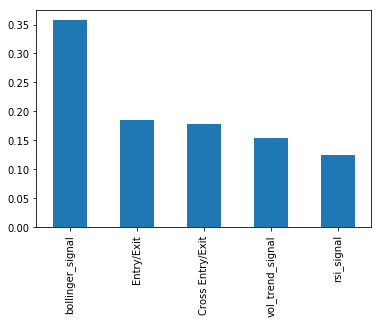

In [51]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [52]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [53]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int64)

In [54]:
results["Predicted Value"].value_counts()

 0    195
 1     19
-1      3
Name: Predicted Value, dtype: int64

In [55]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2020-12-11                0                0
2020-12-12                0                0
2020-12-13                0                0
2020-12-14                0                0
2020-12-15                1                0
2020-12-16                1                1
2020-12-17                1                1
2020-12-18                1                0
2020-12-19                1                0
2020-12-20                1                0

In [56]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

# note 0.69 considered good log loss - the higher the number the more the predicted value diverges from the actual (lower number is better)

1.073884594870087

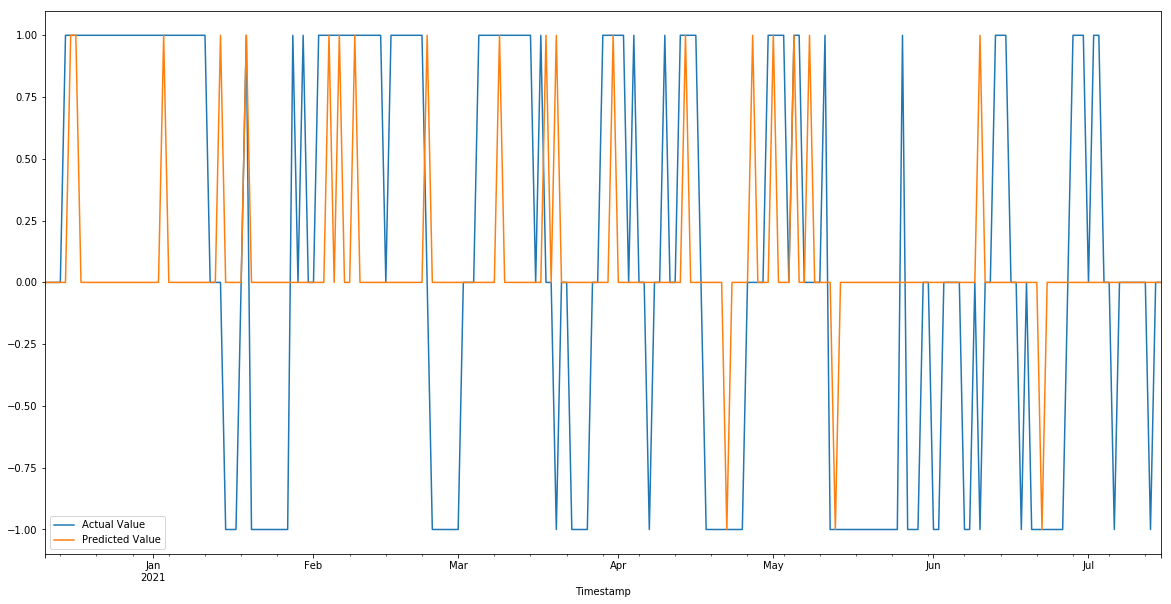

In [57]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

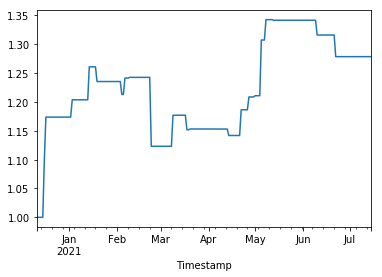

In [58]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

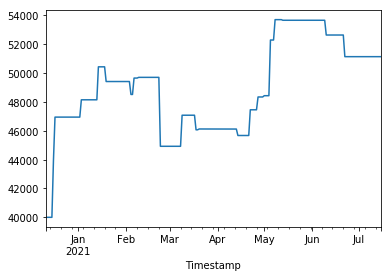

In [59]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [60]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [61]:
cumulative_return_capital.iloc[-1]
annualised_return = cumulative_return_capital.iloc[-1]*2
Full_Period_Year_Return = annualised_return * 3

RF_5_models = Full_Period_Year_Return.item()
RF_5_models


306759.4148993903

## 3 Model Input

In [62]:
trading_signals_df = btc_df.copy()

In [63]:
# Set x variable list of features
x_var_list = ["vol_trend_signal", "bollinger_signal","rsi_signal"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2021-07-11               0.0               0.0         0.0
2021-07-12               0.0               0.0         0.0
2021-07-13               0.0               1.0         0.0
2021-07-14               0.0              -1.0         0.0
2021-07-15               0.0               1.0         0.0

In [64]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2018-07-16               NaN               NaN         NaN
2018-07-17               NaN               NaN         0.0
2018-07-18               0.0               0.0         0.0
2018-07-19               0.0               0.0         0.0
2018-07-20               1.0               0.0         0.0

In [65]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-23  7394.78  7833.00  7375.00  7721.01  41646.346671       0.044115   
2018-07-24  7721.65  8486.00  7696.00  8397.24  60121.163749       0.087583   
2018-07-25  8397.24  8491.77  8050.00  8175.64  48257.649124      -0.026390   
2018-07-26  8175.63  8315.69  7850.06  7920.00  43223.481682      -0.031269   
2018-07-27  7920.00  8285.00  7805.00  8188.57  43671.005891       0.033910   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2018-07-23  0.148387  7436.861970  7373.368746             1.0  ...   
2018-07-24  0.147565  7663.291093  7521.103361             1.0  ...   
2018-07-25  0.107525  7780.629886  7608.768082             1.0  ...   
2018-07-26  0.060779  7811.839468  7647.836339             1.0  ...   
2018-07-27  0.115985  7894.740066  7711.958405             1.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-07-23               0.0                 NaN            NaN   
2018-07-24               0.0                 NaN            NaN   
2018-07-25              -1.0                 NaN            NaN   
2018-07-26               0.0                 NaN            NaN   
2018-07-27               0.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-07-23                   NaN                   NaN             0.0   
2018-07-24                   NaN                   NaN             0.0   
2018-07-25                   NaN                   NaN             0.0   
2018-07-26                   NaN                   NaN             0.0   
2018-07-27                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2018-07-23               0.0  NaN       0.0         0.0  
2018-07-24               0.0  NaN       0.0         0.0  
2018-07-25               0.0  NaN       0.0         0.0  
2018-07-26               0.0  NaN       0.0         0.0  
2018-07-27               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [66]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-23  7394.78  7833.00  7375.00  7721.01  41646.346671       0.044115   
2018-07-24  7721.65  8486.00  7696.00  8397.24  60121.163749       0.087583   
2018-07-25  8397.24  8491.77  8050.00  8175.64  48257.649124      -0.026390   
2018-07-26  8175.63  8315.69  7850.06  7920.00  43223.481682      -0.031269   
2018-07-27  7920.00  8285.00  7805.00  8188.57  43671.005891       0.033910   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2018-07-23  0.148387  7436.861970  7373.368746             1.0  ...   
2018-07-24  0.147565  7663.291093  7521.103361             1.0  ...   
2018-07-25  0.107525  7780.629886  7608.768082             1.0  ...   
2018-07-26  0.060779  7811.839468  7647.836339             1.0  ...   
2018-07-27  0.115985  7894.740066  7711.958405             1.0  ...   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2018-07-23                 NaN            NaN                   NaN   
2018-07-24                 NaN            NaN                   NaN   
2018-07-25                 NaN            NaN                   NaN   
2018-07-26                 NaN            NaN                   NaN   
2018-07-27                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_signal  rsi  \
Timestamp                                                                 
2018-07-23                   NaN             0.0               0.0  NaN   
2018-07-24                   NaN             0.0               0.0  NaN   
2018-07-25                   NaN             0.0               0.0  NaN   
2018-07-26                   NaN             0.0               0.0  NaN   
2018-07-27                   NaN             0.0               0.0  NaN   

            rsi_long  rsi_signal  Positive Return  
Timestamp                                          
2018-07-23       0.0         0.0              1.0  
2018-07-24       0.0         0.0              1.0  
2018-07-25       0.0         0.0              1.0  
2018-07-26       0.0         0.0              1.0  
2018-07-27       0.0         0.0              1.0  

[5 rows x 38 columns]

In [67]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [68]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    448
 1    383
-1    258
Name: Positive Return, dtype: int64

In [69]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-07-23
Training End: 2020-12-10 00:00:00
Testing Start: 2020-12-11 00:00:00
Testing End: 2021-07-15


In [70]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2020-12-06               0.0               0.0        -1.0
2020-12-07               0.0               0.0         0.0
2020-12-08               0.0               0.0         0.0
2020-12-09               0.0               0.0         1.0
2020-12-10               0.0               0.0         0.0

Timestamp
2020-12-06    1
2020-12-07    0
2020-12-08    0
2020-12-09    0
2020-12-10   -1
Name: Positive Return, dtype: int64

In [71]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2021-07-11               0.0               0.0         0.0
2021-07-12               0.0               0.0         0.0
2021-07-13               0.0               0.0         0.0
2021-07-14               0.0               1.0         0.0
2021-07-15               0.0              -1.0         0.0

Timestamp
2021-07-11    0
2021-07-12    0
2021-07-13   -1
2021-07-14    0
2021-07-15    0
Name: Positive Return, dtype: int64

In [72]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    185
 1     30
-1      2
Name: Predicted Value, dtype: int64

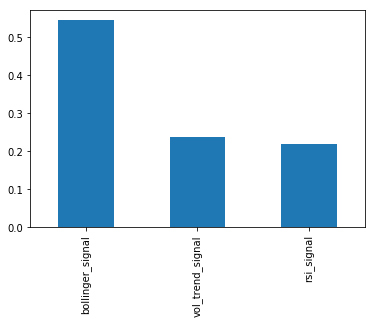

In [73]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [74]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [75]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [76]:
results["Predicted Value"].value_counts()

 0    185
 1     30
-1      2
Name: Predicted Value, dtype: int64

In [77]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2020-12-11                0                0
2020-12-12                0                0
2020-12-13                0                0
2020-12-14                0                0
2020-12-15                1                1
2020-12-16                1                1
2020-12-17                1                1
2020-12-18                1                0
2020-12-19                1                0
2020-12-20                1                0

In [78]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

1.073658502474108

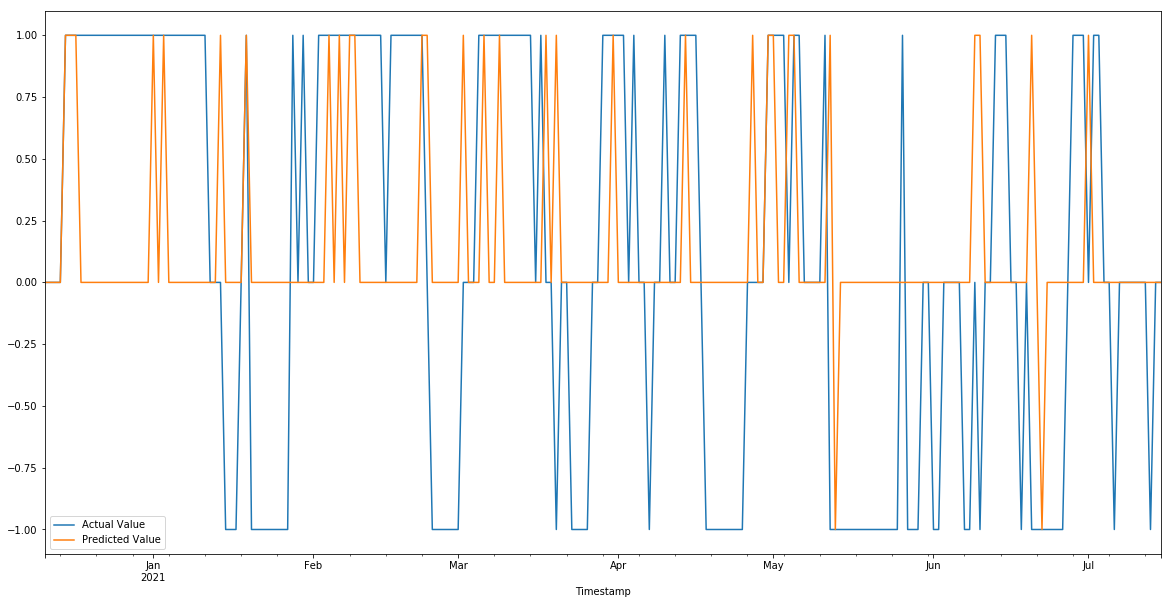

In [79]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

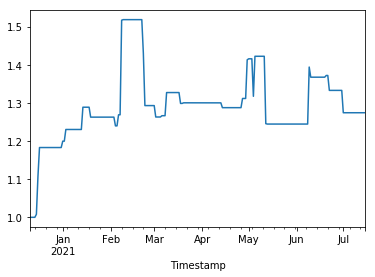

In [80]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

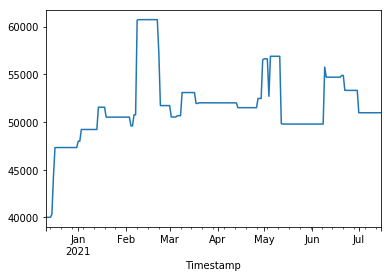

In [81]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [82]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [83]:
cumulative_return_capital.iloc[-1]
annualised_return = cumulative_return_capital.iloc[-1]*2
Full_Period_Year_Return = annualised_return * 3

RF_3_models = Full_Period_Year_Return.item()
RF_3_models


305767.5632680811

## 2 Model Input

In [84]:
trading_signals_df = btc_df.copy()

In [85]:
# Set x variable list of features
x_var_list = ["Cross Entry/Exit","Entry/Exit"]


# Filter by x-variable list
trading_signals_df[x_var_list].tail()

Cross Entry/Exit  Entry/Exit
Timestamp                               
2021-07-11               0.0         0.0
2021-07-12               0.0         0.0
2021-07-13               0.0         0.0
2021-07-14               0.0         0.0
2021-07-15               0.0         0.0

In [86]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

Cross Entry/Exit  Entry/Exit
Timestamp                               
2018-07-16               NaN         NaN
2018-07-17               0.0         NaN
2018-07-18               1.0         0.0
2018-07-19               0.0         0.0
2018-07-20               0.0         0.0

In [87]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-23  7394.78  7833.00  7375.00  7721.01  41646.346671       0.044115   
2018-07-24  7721.65  8486.00  7696.00  8397.24  60121.163749       0.087583   
2018-07-25  8397.24  8491.77  8050.00  8175.64  48257.649124      -0.026390   
2018-07-26  8175.63  8315.69  7850.06  7920.00  43223.481682      -0.031269   
2018-07-27  7920.00  8285.00  7805.00  8188.57  43671.005891       0.033910   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2018-07-23  0.148387  7436.861970  7373.368746             1.0  ...   
2018-07-24  0.147565  7663.291093  7521.103361             1.0  ...   
2018-07-25  0.107525  7780.629886  7608.768082             1.0  ...   
2018-07-26  0.060779  7811.839468  7647.836339             1.0  ...   
2018-07-27  0.115985  7894.740066  7711.958405             1.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-07-23               0.0                 NaN            NaN   
2018-07-24              -1.0                 NaN            NaN   
2018-07-25               0.0                 NaN            NaN   
2018-07-26               0.0                 NaN            NaN   
2018-07-27               0.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-07-23                   NaN                   NaN             0.0   
2018-07-24                   NaN                   NaN             0.0   
2018-07-25                   NaN                   NaN             0.0   
2018-07-26                   NaN                   NaN             0.0   
2018-07-27                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2018-07-23               0.0  NaN       0.0         0.0  
2018-07-24               0.0  NaN       0.0         0.0  
2018-07-25               0.0  NaN       0.0         0.0  
2018-07-26               0.0  NaN       0.0         0.0  
2018-07-27               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [88]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-07-23  7394.78  7833.00  7375.00  7721.01  41646.346671       0.044115   
2018-07-24  7721.65  8486.00  7696.00  8397.24  60121.163749       0.087583   
2018-07-25  8397.24  8491.77  8050.00  8175.64  48257.649124      -0.026390   
2018-07-26  8175.63  8315.69  7850.06  7920.00  43223.481682      -0.031269   
2018-07-27  7920.00  8285.00  7805.00  8188.57  43671.005891       0.033910   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2018-07-23  0.148387  7436.861970  7373.368746             1.0  ...   
2018-07-24  0.147565  7663.291093  7521.103361             1.0  ...   
2018-07-25  0.107525  7780.629886  7608.768082             1.0  ...   
2018-07-26  0.060779  7811.839468  7647.836339             1.0  ...   
2018-07-27  0.115985  7894.740066  7711.958405             1.0  ...   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2018-07-23                 NaN            NaN                   NaN   
2018-07-24                 NaN            NaN                   NaN   
2018-07-25                 NaN            NaN                   NaN   
2018-07-26                 NaN            NaN                   NaN   
2018-07-27                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_signal  rsi  \
Timestamp                                                                 
2018-07-23                   NaN             0.0               0.0  NaN   
2018-07-24                   NaN             0.0               0.0  NaN   
2018-07-25                   NaN             0.0               0.0  NaN   
2018-07-26                   NaN             0.0               0.0  NaN   
2018-07-27                   NaN             0.0               0.0  NaN   

            rsi_long  rsi_signal  Positive Return  
Timestamp                                          
2018-07-23       0.0         0.0              1.0  
2018-07-24       0.0         0.0              1.0  
2018-07-25       0.0         0.0              1.0  
2018-07-26       0.0         0.0              1.0  
2018-07-27       0.0         0.0              1.0  

[5 rows x 38 columns]

In [89]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [90]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    448
 1    383
-1    258
Name: Positive Return, dtype: int64

In [91]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-07-23
Training End: 2020-12-10 00:00:00
Testing Start: 2020-12-11 00:00:00
Testing End: 2021-07-15


In [92]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Cross Entry/Exit  Entry/Exit
Timestamp                               
2020-12-06               0.0         0.0
2020-12-07               0.0         0.0
2020-12-08               0.0         0.0
2020-12-09               0.0         0.0
2020-12-10               0.0         0.0

Timestamp
2020-12-06    1
2020-12-07    0
2020-12-08    0
2020-12-09    0
2020-12-10   -1
Name: Positive Return, dtype: int64

In [93]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Cross Entry/Exit  Entry/Exit
Timestamp                               
2021-07-11               0.0         0.0
2021-07-12               0.0         0.0
2021-07-13               0.0         0.0
2021-07-14               0.0         0.0
2021-07-15               0.0         0.0

Timestamp
2021-07-11    0
2021-07-12    0
2021-07-13   -1
2021-07-14    0
2021-07-15    0
Name: Positive Return, dtype: int64

In [94]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    208
 1      7
-1      2
Name: Predicted Value, dtype: int64

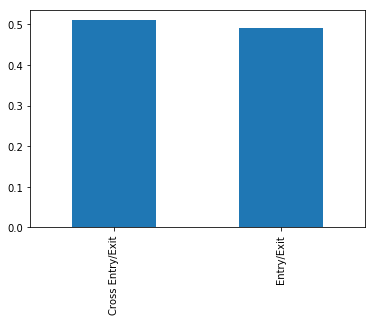

In [95]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [96]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [97]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [98]:
results["Predicted Value"].value_counts()

 0    208
 1      7
-1      2
Name: Predicted Value, dtype: int64

In [99]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2020-12-11                0                0
2020-12-12                0                0
2020-12-13                0                0
2020-12-14                0                0
2020-12-15                1                0
2020-12-16                1                1
2020-12-17                1                0
2020-12-18                1                0
2020-12-19                1                0
2020-12-20                1                0

In [100]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

1.2526922335363913

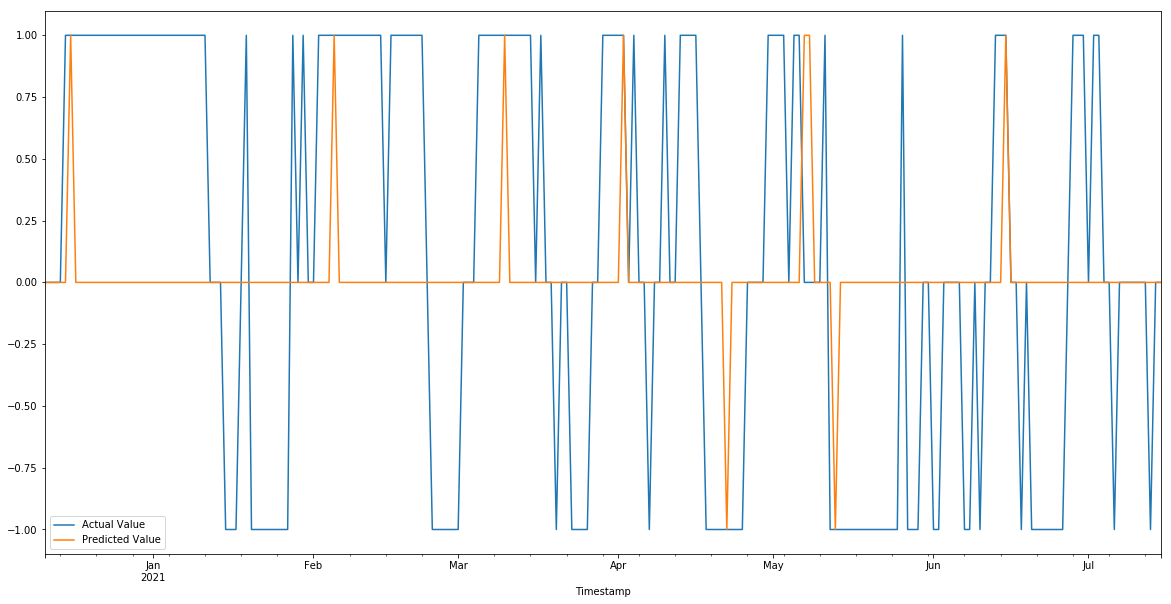

In [101]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

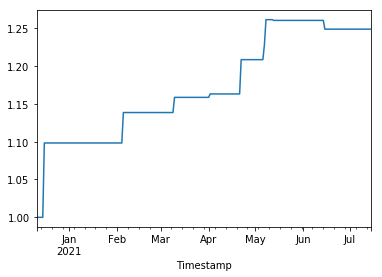

In [102]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

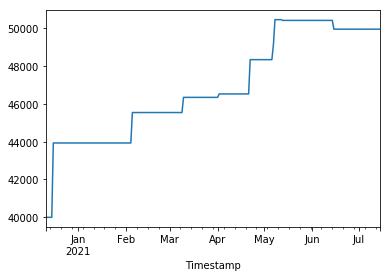

In [103]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [104]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [105]:
cumulative_return_capital.iloc[-1]
annualised_return = cumulative_return_capital.iloc[-1]*2
Full_Period_Year_Return = annualised_return * 3

RF_2_models = Full_Period_Year_Return.item()
RF_2_models


299701.57252144587

### Create new DataFrame to capture results 


In [106]:
comparison_data = [['EWM', EMA ],['SMA', SMA],['Volatility', VOL],['Bollinger', BOL],['RSI', RSI],['RFC_5', RF_5_models],['RFC_3', RF_3_models],['RFC_2', RF_2_models]]
comp_df = pd.DataFrame(comparison_data)
comp_df.columns=['Method','Ending Portfolio Value']
comp_df["% Return on Capital"]=((comp_df["Ending Portfolio Value"]-hounds_cap_investment)/hounds_cap_investment)* 100
comp_df.set_index("Method", inplace= True)
comp_df = comp_df.round(decimals=2)
comp_df = comp_df.sort_values(by=['% Return on Capital'], axis=0, ascending=False)
comp_df


Ending Portfolio Value  % Return on Capital
Method                                                 
EWM                      389983.70               874.96
RFC_5                    306759.41               666.90
RFC_3                    305767.56               664.42
RFC_2                    299701.57               649.25
SMA                      284923.68               612.31
RSI                      263332.80               558.33
Volatility               241834.71               504.59
Bollinger                161522.50               303.81

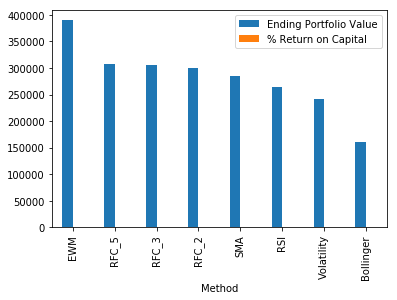

In [107]:
comp_df.plot.bar()